In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
df = pd.read_excel('D:\\Users\\G S VASU\\Desktop\\Abhirama\\IIT Kharagpur\\Projects\\Irrigation Scheduling\\KGP Station Weather Data\\kgp_data.xlsx')

In [5]:
df.head()

,Day of the year,Altitude,Latitude,Longitude,max_temp,min_temp,rainfall,min_RH,max_RH,min_wind_speed,max_wind_speed,evaporation,sunshine hours
0,2018-01-01,53,22°34',87°23',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,53,22°34',87°23',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,53,22°34',87°23',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,53,22°34',87°23',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,53,22°34',87°23',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def convert_to_radians(angle):
    angle = str(angle)  # Convert angle to string
    parts = angle.split('°')
    degrees = int(parts[0])
    minutes = int(parts[1].rstrip('\''))
    total_minutes = degrees * 60 + minutes
    radians = math.radians(total_minutes / 60)
    return radians

In [7]:
df['Latitude'] = df['Latitude'].apply(convert_to_radians)
df['Longitude'] = df['Longitude'].apply(convert_to_radians)

In [8]:
cols = []
for i in range(len(df.columns)):
    if(df.dtypes[i]!='<M8[ns]'):
        cols.append(df.columns[i])

In [9]:
for col in cols:
    df[col] = df[col].astype(float)

In [10]:
df1 = df.dropna()

In [11]:
df1.head()

,Day of the year,Altitude,Latitude,Longitude,max_temp,min_temp,rainfall,min_RH,max_RH,min_wind_speed,max_wind_speed,evaporation,sunshine hours
423,2019-02-28,53.0,0.393863,1.525127,25.2,17.2,2.0,96.0,96.0,6.0,6.0,2.0,5.20
424,2019-03-01,53.0,0.393863,1.525127,25.0,16.4,0.0,73.0,73.0,6.0,6.0,2.5,8.00
425,2019-03-02,53.0,0.393863,1.525127,26.7,15.5,0.0,71.0,71.0,4.0,4.0,2.6,7.00
427,2019-03-04,53.0,0.393863,1.525127,29.2,16.2,2.2,84.0,84.0,2.0,2.0,2.1,0.00
428,2019-03-05,53.0,0.393863,1.525127,29.0,19.4,0.0,96.0,96.0,2.0,2.0,2.0,5.45


In [12]:
df1['wind_speed'] = df1[['min_wind_speed', 'max_wind_speed']].mean(axis=1)
df1['mean_temp'] = df1[['min_temp', 'max_temp']].mean(axis=1)

In [13]:
df1['mean_RH'] = df1[['min_RH', 'max_RH']].mean(axis=1)

In [14]:
df1['max_DPT'] = (4030 * (235 + df1['max_temp']) / (4030 - ((df1['max_temp'] + 235) * np.log(df1['max_RH'] / 100)))) - 235
df1['min_DPT'] = (4030 * (235 + df1['min_temp']) / (4030 - ((df1['min_temp'] + 235) * np.log(df1['min_RH'] / 100)))) - 235
df1['mean_DPT'] = df1[['max_DPT', 'min_DPT']].mean(axis=1)

In [15]:
df1['Julian Day'] = df1['Day of the year'].dt.dayofyear

In [16]:
#Constants
lambdaa = 2.45                                                                                                      #Latent Heat of Vapourization
alpha = 0.23                                                                                                        #Albedo / Crop Canopy Coefficient
sigma = 4.903e-9                                                                                                    #Stefan-Bolzmann Constant
Gsc = 0.082                                                                                                         #Solar Constant

In [17]:
import math
PI = math.pi
df1['solar_dec'] = 0.409 * np.sin((2 * PI * df1['Julian Day']/ 365) - 1.39)
df1['dr'] = 1 + 0.033 * np.cos(2 * PI * df1['Julian Day'] / 365)
df1['ws'] = np.arccos(-np.tan(df1['Latitude']) * np.tan(df1['solar_dec']))
df1['N'] = 24 * df1['ws'] / PI
df1['sinx'] = (df1['ws'] * np.sin(df1['Latitude']) * np.sin(df1['solar_dec'])) + (np.cos(df1['Latitude']) * np.cos(df1['solar_dec']))
df1['Ra'] = 24 * 60 * Gsc * df1['dr'] * df1['sinx'] / PI
df1['Rs'] = (0.25 + (0.5 * (df1['sunshine hours'] / df1['N']))) * df1['Ra']
df1['Rso'] = (0.75 + (2e-5 * df1['Altitude'])) * df1['Ra']
df1['f '] = (1.35 * df1['Rs'] / df1['Rso']) - 0.35
df1['ea'] = 0.6108 * (np.exp(17.27 * df1['mean_DPT'] / (df1['mean_DPT'] + 237.3)))
df1['es'] = 0.6108 * (np.exp(17.27 * df1['mean_temp'] / (df1['mean_temp'] + 237.3)))
df1['epsilon'] = 0.34 - (0.14 * np.sqrt(df1['ea']))
df1['delta'] = 4098 * df1['es'] / (df1['mean_temp'] + 237.3) ** 2
df1['Bp'] = 101.3 * ((1 - (0.0000221843 *df1['Altitude'])) ** 5.6)
df1['gamma'] = 0.00163*df1['Bp']/lambdaa
df1['Rns'] = (1-alpha)*df1['Rs']
df1['Rnl'] = df1['f ']*df1['epsilon']*sigma*(df1['mean_temp'] + 273.15)**4
df1['Solar Radiation'] = df1['Rns'] - df1['Rnl']
G = 0
df1['numerator'] = 0.408*df1['delta']*(df1['Solar Radiation']-G) + df1['gamma']*df1['wind_speed']*900*(df1['es']-df1['ea'])/(df1['mean_temp']+273)
df1['denominator'] = df1['delta'] + df1['gamma']*(1+(0.34*df1['wind_speed']))
df1['ETo'] = df1['numerator']/df1['denominator']

In [18]:
df1.columns

Index(['Day of the year', 'Altitude', 'Latitude', 'Longitude', 'max_temp',
       'min_temp', 'rainfall', 'min_RH', 'max_RH', 'min_wind_speed',
       'max_wind_speed', 'evaporation', 'sunshine hours', 'wind_speed',
       'mean_temp', 'mean_RH', 'max_DPT', 'min_DPT', 'mean_DPT', 'Julian Day',
       'solar_dec', 'dr', 'ws', 'N', 'sinx', 'Ra', 'Rs', 'Rso', 'f ', 'ea',
       'es', 'epsilon', 'delta', 'Bp', 'gamma', 'Rns', 'Rnl',
       'Solar Radiation', 'numerator', 'denominator', 'ETo'],
      dtype='object')

In [22]:
df2 = df1[['max_temp', 'min_temp', 'mean_temp', 'max_RH', 'min_RH', 'mean_RH',
       'max_DPT', 'min_DPT', 'mean_DPT', 'wind_speed', 'rainfall',
       'sunshine hours', 'Solar Radiation','ETo']]

In [23]:
df2.head()

,max_temp,min_temp,mean_temp,max_RH,min_RH,mean_RH,max_DPT,min_DPT,mean_DPT,wind_speed,rainfall,sunshine hours,Solar Radiation,ETo
423,25.2,17.2,21.2,96.0,96.0,96.0,24.515993,16.557355,20.536674,6.0,2.0,5.20,9.307349,1.983537
424,25.0,16.4,20.7,73.0,73.0,73.0,19.826033,11.559464,15.692748,6.0,0.0,8.00,10.554828,4.120637
425,26.7,15.5,21.1,71.0,71.0,71.0,21.006261,10.278321,15.642291,4.0,0.0,7.00,9.962412,3.910805
427,29.2,16.2,22.7,84.0,84.0,84.0,26.214239,13.499338,19.856789,2.0,2.2,0.00,5.733939,2.041599
428,29.0,19.4,24.2,96.0,96.0,96.0,28.295895,18.746109,23.521002,2.0,0.0,5.45,10.056357,2.697164


In [21]:
df2.columns

Index(['max_temp', 'min_temp', 'mean_temp', 'max_RH', 'min_RH', 'mean_RH',
       'max_DPT', 'min_DPT', 'mean_DPT', 'wind_speed', 'rainfall',
       'sunshine hours', 'evaporation', 'Solar Radiation', 'ETo'],
      dtype='object')

In [91]:
df2.shape

(1150, 15)

In [24]:
x = df2.drop(['ETo'],axis=1)
y = df2.ETo

In [25]:
x.describe()

,max_temp,min_temp,mean_temp,max_RH,min_RH,mean_RH,max_DPT,min_DPT,mean_DPT,wind_speed,rainfall,sunshine hours,Solar Radiation
count,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000
mean,31.115739,19.928348,25.522043,67.005270,74.222148,70.613709,23.836470,14.848053,19.342261,4.763261,4.219913,5.308783,9.185085
std,3.938839,5.226034,4.277548,15.130778,15.463473,13.398430,5.376605,7.629846,6.104118,1.838847,15.027228,3.137724,2.933528
min,20.000000,6.400000,13.950000,4.000000,11.000000,30.450000,-17.110347,-19.064393,-4.727879,0.100000,0.000000,0.000000,4.002487
25%,28.500000,15.600000,22.012500,57.000000,66.000000,61.500000,19.682417,9.447534,14.595932,4.000000,0.000000,2.825000,6.933327
50%,31.500000,20.500000,26.525000,68.000000,77.000000,71.500000,24.679607,16.332344,19.933677,5.000000,0.000000,6.050000,8.764459
75%,34.000000,24.600000,29.050000,78.000000,84.000000,80.000000,28.420985,21.364292,24.784841,5.500000,0.600000,8.000000,11.285327
max,42.000000,28.000000,33.950000,100.000000,100.000000,100.000000,34.617867,27.478250,29.293761,30.500000,259.000000,11.500000,18.024855


In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [27]:
import os
os.getcwd()
#change the directory
os.chdir('D:\\Users\\G S VASU\\Desktop\\Abhirama\\IIT Kharagpur\\Projects\\Irrigation Scheduling\\25 Stations Weather Data')

In [28]:
import pickle
with open('RF Model.pickle','rb') as f:
  model = pickle.load(f)

In [29]:
model.score(x_scaled,y)

0.5535397827554731

In [30]:
import pickle
with open('MLP_model.pickle','rb') as f:
  mlp_model = pickle.load(f)

In [31]:
mlp_model.score(x_scaled,y)

0.6173567861877327

In [110]:
mlp_model.score(x_scaled,y)

0.6344149961807469

In [111]:
model.score(x_scaled,y)

0.5451866386362365

In [102]:
model

RandomForestRegressor(bootstrap=False, max_depth=92, max_features=6,
                      min_samples_leaf=2, n_estimators=201)

In [98]:
model.score(x_scaled,y)

0.5451866386362365

In [43]:
y_prediction = model.predict(x_scaled)

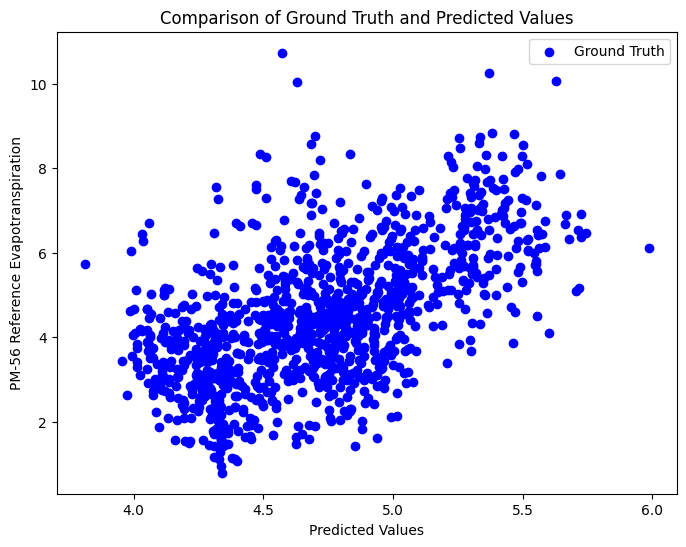

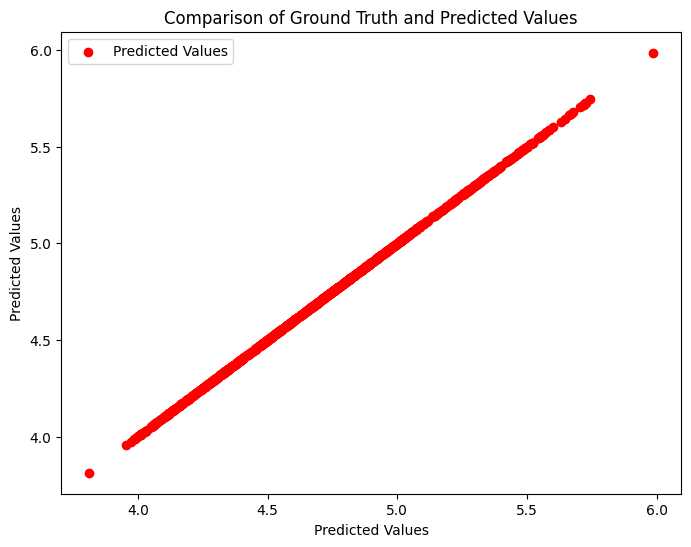

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(y_prediction, y, color='blue', label='Ground Truth')
plt.xlabel('Predicted Values')
plt.ylabel('PM-56 Reference Evapotranspiration')
plt.title('Comparison of Ground Truth and Predicted Values')
plt.legend()
plt.show()
#plot the x and y axis values on the same scale
plt.figure(figsize=(8, 6))
plt.scatter(y_prediction, y_prediction, color='red', label='Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Ground Truth and Predicted Values')
plt.legend()
plt.show() 

In [44]:
y_prediction = pd.DataFrame(y_prediction)

In [45]:
#append the predicted values to the original dataframe
df2['ETo_predicted'] = y_prediction

In [46]:
df2

,max_temp,min_temp,mean_temp,sunshine hours,evaporation,Solar Radiation,ETo,ETo_predicted
423,25.2,17.2,21.20,5.20,2.0,9.307349,1.983537,6.2675
424,25.0,16.4,20.70,8.00,2.5,10.554828,4.120637,6.1154
425,26.7,15.5,21.10,7.00,2.6,9.962412,3.910805,6.1539
427,29.2,16.2,22.70,0.00,2.1,5.733939,2.041599,6.8051
428,29.0,19.4,24.20,5.45,2.0,10.056357,2.697164,6.3979
...,...,...,...,...,...,...,...,...
1920,35.8,21.5,28.65,8.20,8.0,12.317648,7.147996,NaN
1921,35.8,23.0,29.40,8.20,8.0,11.783705,8.604853,NaN
1922,36.2,24.0,30.10,7.80,6.0,12.134276,8.296334,NaN
1923,36.8,24.4,30.60,8.50,6.0,13.274949,7.819316,NaN
